## 1. The most Nobel of Prizes
<p><img style="float: right;margin:5px 20px 5px 1px; max-width:250px" src="https://assets.datacamp.com/production/project_441/img/Nobel_Prize.png"></p>
<p>The Nobel Prize is perhaps the world's most well known scientific award. Except for the honor, prestige and substantial prize money the recipient also gets a gold medal showing Alfred Nobel (1833 - 1896) who established the prize. Every year it's given to scientists and scholars in the categories chemistry, literature, physics, physiology or medicine, economics, and peace. The first Nobel Prize was handed out in 1901, and at that time the Prize was very Eurocentric and male-focused, but nowadays it's not biased in any way whatsoever. Surely. Right?</p>
<p>Well, we're going to find out! The Nobel Foundation has made a dataset available of all prize winners from the start of the prize, in 1901, to 2016. Let's load it in and take a look.</p>

In [1]:
import glob
import itertools
import json
import os
import pickle
import random
import re
import statistics
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import requests
import scipy as sp
import seaborn as sns
from dotenv import load_dotenv

%matplotlib inline
import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from matplotlib.ticker import PercentFormatter

# dot env for secrets
load_dotenv()
some_apikey = os.getenv("SOME_KEY")

# mapbox
TOKEN = os.getenv("MAPBOX_TOKEN")
px.set_mapbox_access_token(TOKEN)
MAPBOX_STYLE = "dark"
MAPBOX_HEIGHT = 800

# matplotlib configs
matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")
plt.style.use("seaborn-colorblind")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Open Sans"
rcParams["figure.figsize"] = 15, 6
sns.set_palette("colorblind")

# watermark
%reload_ext watermark
%watermark -a 'Ken Cavagnolo' -n -u -v -m -h -g -p jupyter,notebook,pandas,numpy,scipy

Author: Ken Cavagnolo

Last updated: Thu Aug 05 2021

Python implementation: CPython
Python version       : 3.8.0
IPython version      : 7.25.0

jupyter : 1.0.0
notebook: 6.4.0
pandas  : 1.3.0
numpy   : 1.21.0
scipy   : 1.7.0

Compiler    : GCC 10.3.0
OS          : Linux
Release     : 5.11.0-7620-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit

Hostname: goldfinch

Git hash: 6d97e7dbe625d21c70ad1f12709337bdeb680ec4



In [51]:
# Reading in the Nobel Prize data
nobel = pd.read_csv('datasets/nobel.csv')

# Taking a look at the first several winners
nobel.head()

,year,category,prize,motivation,prize_share,laureate_id,laureate_type,full_name,birth_date,birth_city,birth_country,sex,organization_name,organization_city,organization_country,death_date,death_city,death_country
0,1901,Chemistry,The Nobel Prize in Chemistry 1901,"""in recognition of the extraordinary services ...",1/1,160,Individual,Jacobus Henricus van 't Hoff,1852-08-30,Rotterdam,Netherlands,Male,Berlin University,Berlin,Germany,1911-03-01,Berlin,Germany
1,1901,Literature,The Nobel Prize in Literature 1901,"""in special recognition of his poetic composit...",1/1,569,Individual,Sully Prudhomme,1839-03-16,Paris,France,Male,NaN,NaN,NaN,1907-09-07,Châtenay,France
2,1901,Medicine,The Nobel Prize in Physiology or Medicine 1901,"""for his work on serum therapy, especially its...",1/1,293,Individual,Emil Adolf von Behring,1854-03-15,Hansdorf (Lawice),Prussia (Poland),Male,Marburg University,Marburg,Germany,1917-03-31,Marburg,Germany
3,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,462,Individual,Jean Henry Dunant,1828-05-08,Geneva,Switzerland,Male,NaN,NaN,NaN,1910-10-30,Heiden,Switzerland
4,1901,Peace,The Nobel Peace Prize 1901,NaN,1/2,463,Individual,Frédéric Passy,1822-05-20,Paris,France,Male,NaN,NaN,NaN,1912-06-12,Paris,France


## 2. So, who gets the Nobel Prize?
<p>Just looking at the first couple of prize winners, or Nobel laureates as they are also called, we already see a celebrity: Wilhelm Conrad Röntgen, the guy who discovered X-rays. And actually, we see that all of the winners in 1901 were guys that came from Europe. But that was back in 1901, looking at all winners in the dataset, from 1901 to 2016, which sex and which country is the most commonly represented? </p>
<p>(For <em>country</em>, we will use the <code>birth_country</code> of the winner, as the <code>organization_country</code> is <code>NaN</code> for all shared Nobel Prizes.)</p>

In [3]:
# Display the number of (possibly shared) Nobel Prizes handed
# out between 1901 and 2016
display(len(nobel))

# Display the number of prizes won by male and female recipients.
display(nobel['sex'].value_counts())

# Display the number of prizes won by the top 10 nationalities.
nobel['birth_country'].value_counts().head(10)

911

Male      836
Female     49
Name: sex, dtype: int64

United States of America    259
United Kingdom               85
Germany                      61
France                       51
Sweden                       29
Japan                        24
Canada                       18
Netherlands                  18
Italy                        17
Russia                       17
Name: birth_country, dtype: int64

## 3. USA dominance
<p>Not so surprising perhaps: the most common Nobel laureate between 1901 and 2016 was a man born in the United States of America. But in 1901 all the winners were European. When did the USA start to dominate the Nobel Prize charts?</p>

In [4]:
# Calculating the proportion of USA born winners per decade
nobel['usa_born_winner'] = nobel.birth_country == 'United States of America'
nobel['decade'] = nobel.year.apply(lambda x: (np.floor(x / 10) * 10).astype(int))
prop_usa_winners = nobel.groupby('decade', as_index=False).usa_born_winner.mean()

# Display the proportions of USA born winners per decade
print(prop_usa_winners)

    decade  usa_born_winner
0     1900         0.017544
1     1910         0.075000
2     1920         0.074074
3     1930         0.250000
4     1940         0.302326
5     1950         0.291667
6     1960         0.265823
7     1970         0.317308
8     1980         0.319588
9     1990         0.403846
10    2000         0.422764
11    2010         0.292683


## 4. USA dominance, visualized
<p>A table is OK, but to <em>see</em> when the USA started to dominate the Nobel charts we need a plot!</p>

Text(0.5, 1.0, 'US Born Winners')

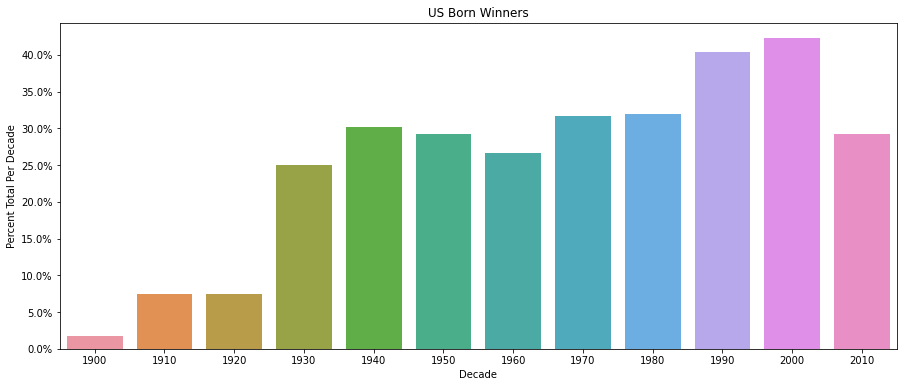

In [10]:
# Plotting USA born winners 
ax = sns.barplot(data=prop_usa_winners, x="decade", y="usa_born_winner")

# Adding %-formatting to the y-axis
from matplotlib.ticker import PercentFormatter
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Decade")
ax.set_ylabel("Percent Total Per Decade")
ax.set_title("US Born Winners")

## 5. What is the gender of a typical Nobel Prize winner?
<p>So the USA became the dominating winner of the Nobel Prize first in the 1930s and had kept the leading position ever since. But one group that was in the lead from the start, and never seems to let go, are <em>men</em>. Maybe it shouldn't come as a shock that there is some imbalance between how many male and female prize winners there are, but how significant is this imbalance? And is it better or worse within specific prize categories like physics, medicine, literature, etc.?</p>

Text(0.5, 1.0, 'Female Winners Per Category')

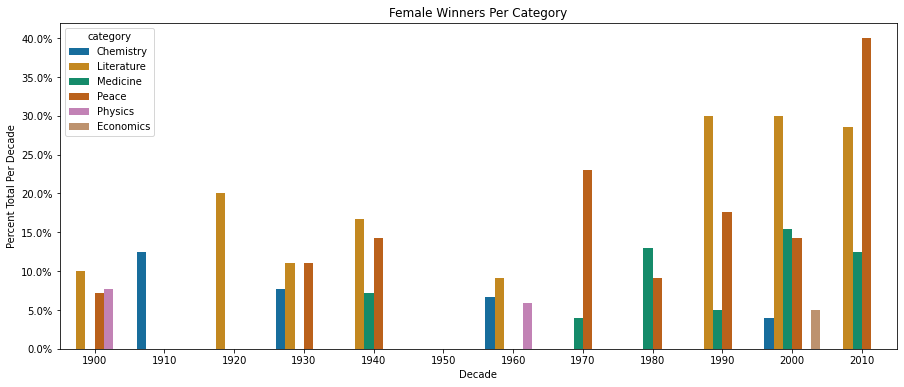

In [22]:
# Calculating the proportion of female laureates per decade
nobel['female_winner'] = nobel.sex == "Female"
prop_female_winners = nobel.groupby(["decade", "category"], as_index=False).female_winner.mean()

# Plotting USA born winners with % winners on the y-axis
ax = sns.barplot(x='decade', y='female_winner', hue="category", data=prop_female_winners)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Decade")
ax.set_ylabel("Percent Total Per Decade")
ax.set_title("Female Winners Per Category")

## 6. The first woman to win the Nobel Prize
<p>The plot above is a bit messy as the lines are overplotting. But it does show some interesting trends and patterns. Overall the imbalance is pretty large with physics, economics, and chemistry having the largest imbalance. Medicine has a somewhat positive trend, and since the 1990s the literature prize is also now more balanced. The big outlier is the peace prize during the 2010s, but keep in mind that this just covers the years 2010 to 2016.</p>
<p>Given this imbalance, who was the first woman to receive a Nobel Prize? And in what category?</p>

In [28]:
# Picking out the first woman to win a Nobel Prize
nobel[(nobel.sex == "Female")].nsmallest(1, "year").full_name

19    Marie Curie, née Sklodowska
Name: full_name, dtype: object

## 7. Repeat laureates
<p>For most scientists/writers/activists a Nobel Prize would be the crowning achievement of a long career. But for some people, one is just not enough, and few have gotten it more than once. Who are these lucky few? (Having won no Nobel Prize myself, I'll assume it's just about luck.)</p>

In [35]:
# Selecting the laureates that have received 2 or more prizes.
#nobel.groupby('full_name').filter(lambda group: len(group) >= 2)
nobel.full_name.value_counts(ascending=False).nlargest(10)

Comité international de la Croix Rouge (International Committee of the Red Cross)    3
Office of the United Nations High Commissioner for Refugees (UNHCR)                  2
John Bardeen                                                                         2
Linus Carl Pauling                                                                   2
Frederick Sanger                                                                     2
Marie Curie, née Sklodowska                                                          2
Jacobus Henricus van 't Hoff                                                         1
Ronald H. Coase                                                                      1
Octavio Paz                                                                          1
Joseph E. Murray                                                                     1
Name: full_name, dtype: int64

## 8. How old are you when you get the prize?
<p>The list of repeat winners contains some illustrious names! We again meet Marie Curie, who got the prize in physics for discovering radiation and in chemistry for isolating radium and polonium. John Bardeen got it twice in physics for transistors and superconductivity, Frederick Sanger got it twice in chemistry, and Linus Carl Pauling got it first in chemistry and later in peace for his work in promoting nuclear disarmament. We also learn that organizations also get the prize as both the Red Cross and the UNHCR have gotten it twice.</p>
<p>But how old are you generally when you get the prize?</p>

Text(0.5, 1.0, 'Average Winner Ager Per Decade')

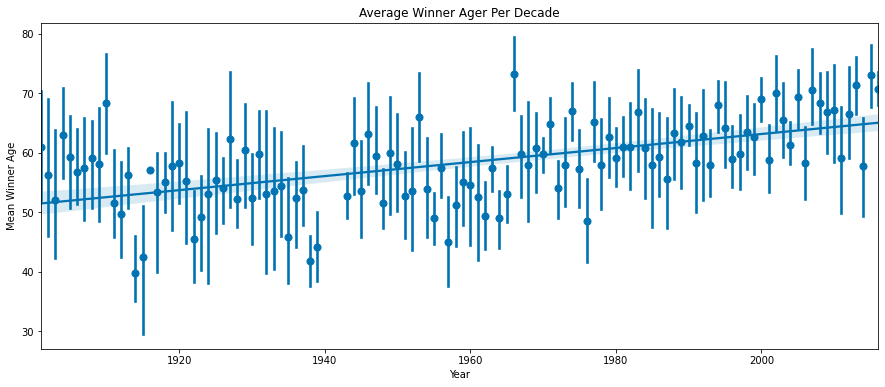

In [53]:
# Converting birth_date from String to datetime
nobel['birth_date'] = pd.to_datetime(nobel.birth_date)

# Calculating the age of Nobel Prize winners
nobel['age'] = nobel.year - nobel.birth_date.dt.year

# Plotting the age of Nobel Prize winners
g = sns.regplot(data=nobel, x="year", y="age", x_estimator=np.mean)
g.set_xlabel("Year")
g.set_ylabel("Mean Winner Age")
g.set_title("Average Winner Ager Per Decade")

## 9. Age differences between prize categories
<p>The plot above shows us a lot! We see that people use to be around 55 when they received the price, but nowadays the average is closer to 65. But there is a large spread in the laureates' ages, and while most are 50+, some are very young.</p>
<p>We also see that the density of points is much high nowadays than in the early 1900s -- nowadays many more of the prizes are shared, and so there are many more winners. We also see that there was a disruption in awarded prizes around the Second World War (1939 - 1945). </p>
<p>Let's look at age trends within different prize categories.</p>

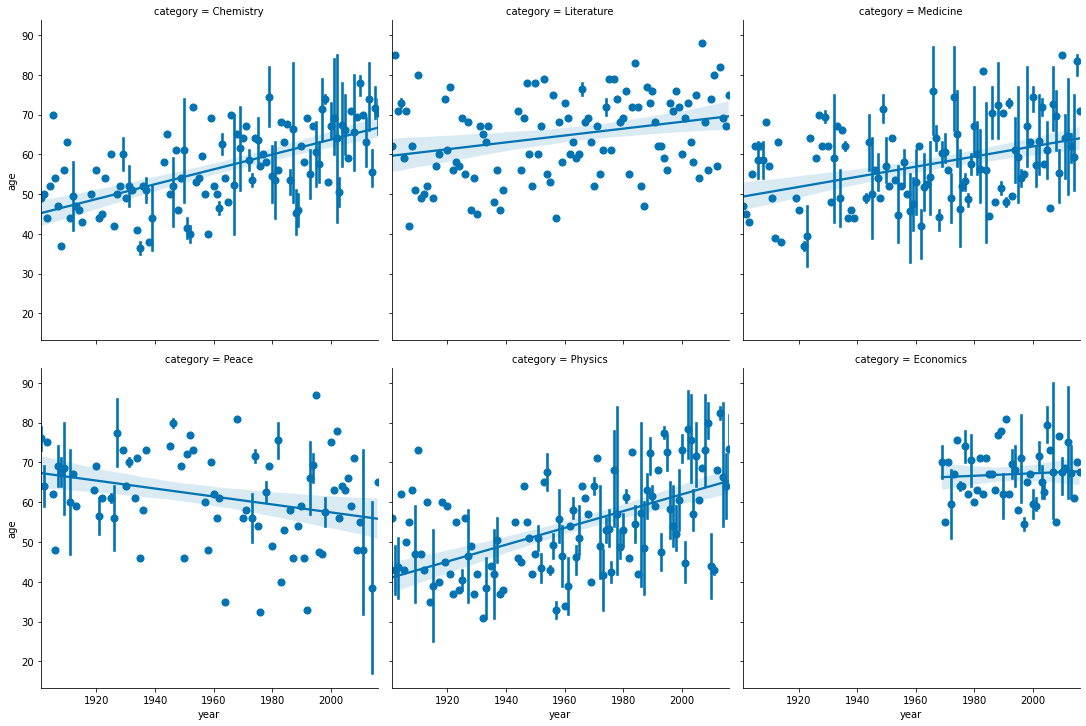

In [59]:
# Same plot as above, but separate plots for each type of Nobel Prize
sns.lmplot(data=nobel,
           x="year",
           y="age",
           col="category",
           col_wrap=3,
           x_estimator=np.mean)

## 10. Oldest and youngest winners
<p>More plots with lots of exciting stuff going on! We see that both winners of the chemistry, medicine, and physics prize have gotten older over time. The trend is strongest for physics: the average age used to be below 50, and now it's almost 70. Literature and economics are more stable. We also see that economics is a newer category. But peace shows an opposite trend where winners are getting younger! </p>
<p>In the peace category we also a winner around 2010 that seems exceptionally young. This begs the questions, who are the oldest and youngest people ever to have won a Nobel Prize?</p>

In [72]:
# The oldest winner of a Nobel Prize as of 2016
print(f'Oldest: {nobel.nlargest(1, "age").full_name.values[0]}')

# The youngest winner of a Nobel Prize as of 2016
print(f'Youngest: {nobel.nsmallest(1, "age").full_name.values[0]}')

Oldest: Leonid Hurwicz
Youngest: Malala Yousafzai


## 11. You get a prize!
<p><img style="float: right;margin:20px 20px 20px 20px; max-width:200px" src="https://assets.datacamp.com/production/project_441/img/paint_nobel_prize.png"></p>
<p>Hey! You get a prize for making it to the very end of this notebook! It might not be a Nobel Prize, but I made it myself in paint so it should count for something. But don't despair, Leonid Hurwicz was 90 years old when he got his prize, so it might not be too late for you. Who knows.</p>
<p>Before you leave, what was again the name of the youngest winner ever who in 2014 got the prize for "[her] struggle against the suppression of children and young people and for the right of all children to education"?</p>

In [73]:
# The name of the youngest winner of the Nobel Prize as of 2016
youngest_winner = 'Malala Yousafzai'